In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred, average = 'macro')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, macro f1_score: {3:.4f}'.format(accuracy, precision, recall, f1))

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/신용카드AI/ADASYN/train_adasyn3.csv',index_col=0)
valid_df = pd.read_csv('/content/drive/MyDrive/신용카드AI/val.csv')
valid_df.drop(['ID'], axis=1, inplace=True)
test_df = pd.read_csv('/content/drive/MyDrive/신용카드AI/test.csv')
test_df.drop(['ID'], axis=1, inplace=True)
print(train_df.shape, valid_df.shape, test_df.shape)
print('train_smote data 이상치 비율:', train_df[train_df['Class'] == 1].shape[0] / train_df.shape[0])
print('valid data 이상치 비율:', valid_df[valid_df['Class'] == 1].shape[0] / valid_df.shape[0])

(227498, 31) (28462, 31) (142503, 30)
train_smote data 이상치 비율: 0.4999956043569614
valid data 이상치 비율: 0.0010540369615627855


In [9]:
X_train, y_train, X_valid, y_valid = train_df.iloc[:, :-1], train_df['Class'], valid_df.iloc[:, :-1], valid_df['Class']

## 단일 모델(adaboost, xgboost, lgbm) 최적 파라미터 사용용

In [10]:
base_model = DecisionTreeClassifier(max_depth=5, random_state=0)
ada_clf = AdaBoostClassifier(base_estimator = base_model, n_estimators=100, random_state=42, learning_rate=0.01)
lgbm_clf = LGBMClassifier(learning_rate = 0.01)
xgb_clf = XGBClassifier(n_estimators=2000, max_depth=6, subsample=0.5, learning_rate=0.1, objective='binary:logistic', tree_method='gpu_hist', gpu_id=0, random_state=0)

## Hard Voting

In [11]:
vo_clf = VotingClassifier(estimators=[('ADA', ada_clf), ('LGBM', lgbm_clf), ('XGB', xgb_clf)], voting='hard')
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('ADA',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                       random_state=0),
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('LGBM', LGBMClassifier(learning_rate=0.01)),
                             ('XGB',
                              XGBClassifier(gpu_id=0, max_depth=6,
                                            n_estimators=2000, subsample=0.5,
                                            tree_method='gpu_hist'))])

In [12]:
vo_pred_valid = vo_clf.predict(X_valid)
get_clf_eval(y_valid, vo_pred_valid)

오차 행렬
[[28430     2]
 [    8    22]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.7333, macro f1_score: 0.9073


In [13]:
'''vo_pred_test = vo_clf.predict(test_df)

SyntaxError: ignored

In [ ]:
'''test_df = pd.read_csv('/content/drive/MyDrive/신용카드AI/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, vo_pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

In [ ]:
'''final_test_pred.to_csv('/content/drive/MyDrive/신용카드AI/ADASYN/test_pred_hard_voting.csv', index = False)

## Soft Voting

In [14]:
vo_clf = VotingClassifier(estimators=[('ADA', ada_clf), ('LGBM', lgbm_clf), ('XGB', xgb_clf)], voting='soft')
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('ADA',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                       random_state=0),
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('LGBM', LGBMClassifier(learning_rate=0.01)),
                             ('XGB',
                              XGBClassifier(gpu_id=0, max_depth=6,
                                            n_estimators=2000, subsample=0.5,
                                            tree_method='gpu_hist'))],
                 voting='soft')

In [15]:
vo_pred_valid = vo_clf.predict(X_valid)
get_clf_eval(y_valid, vo_pred_valid)

오차 행렬
[[28430     2]
 [    8    22]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.7333, macro f1_score: 0.9073


In [22]:
# 시각화용 df 생성
# 기존 valid features + 기존 valid class
valid_pred_df = pd.DataFrame(np.concatenate((valid_df.drop('Class',axis=1).values, vo_pred_valid.reshape(-1, 1)), axis=1), columns = valid_df.columns)

# 기존 valid features + 예측 valid class
valid_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,-0.077753,...,0.778817,-0.175451,0.030397,0.018381,-0.395994,0.301655,0.173585,0.202753,1.034622,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,-1.245088,...,-0.431876,0.141759,0.587119,-0.200998,0.267337,-0.152951,-0.065285,0.810452,1.034693,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,0.076605,...,0.305268,-0.148093,-0.038712,0.010209,-0.362666,0.503092,0.229921,0.537972,1.034763,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,-0.269964,1.034928,0


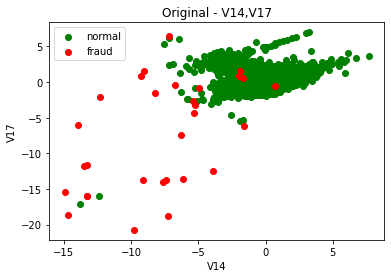

In [34]:
plt.scatter(valid_df[valid_df['Class']==0].V14, valid_df[valid_df['Class']==0].V17, color='green', label= 'normal')
plt.scatter(valid_df[valid_df['Class']==1].V14, valid_df[valid_df['Class']==1].V17, color='red', label= 'fraud')
plt.xlabel('V14')
plt.ylabel('V17')
plt.title('Original - V14,V17')
plt.legend()
plt.show()

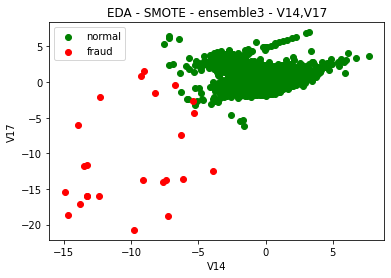

In [35]:
plt.scatter(valid_pred_df[valid_pred_df['Class']==0].V14, valid_pred_df[valid_pred_df['Class']==0].V17, color='green', label= 'normal')
plt.scatter(valid_pred_df[valid_pred_df['Class']==1].V14, valid_pred_df[valid_pred_df['Class']==1].V17, color='red', label= 'fraud')
plt.xlabel('V14')
plt.ylabel('V17')
plt.title('EDA - SMOTE - ensemble3 - V14,V17')
plt.legend()
plt.show()

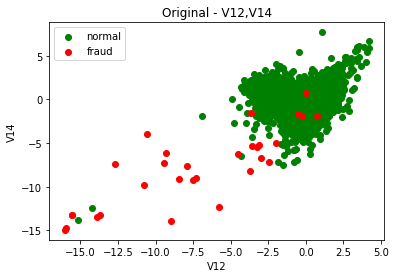

In [36]:
plt.scatter(valid_df[valid_df['Class']==0].V12, valid_df[valid_df['Class']==0].V14, color='green', label= 'normal')
plt.scatter(valid_df[valid_df['Class']==1].V12, valid_df[valid_df['Class']==1].V14, color='red', label= 'fraud')
plt.xlabel('V12')
plt.ylabel('V14')
plt.title('Original - V12,V14')
plt.legend()
plt.show()

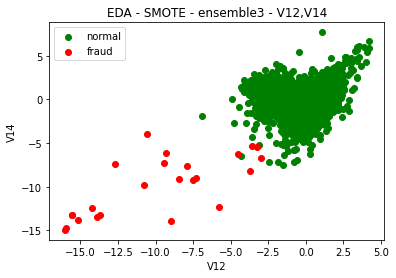

In [37]:
plt.scatter(valid_pred_df[valid_pred_df['Class']==0].V12, valid_pred_df[valid_pred_df['Class']==0].V14, color='green', label= 'normal')
plt.scatter(valid_pred_df[valid_pred_df['Class']==1].V12, valid_pred_df[valid_pred_df['Class']==1].V14, color='red', label= 'fraud')
plt.xlabel('V12')
plt.ylabel('V14')
plt.title('EDA - SMOTE - ensemble3 - V12,V14')
plt.legend()
plt.show()

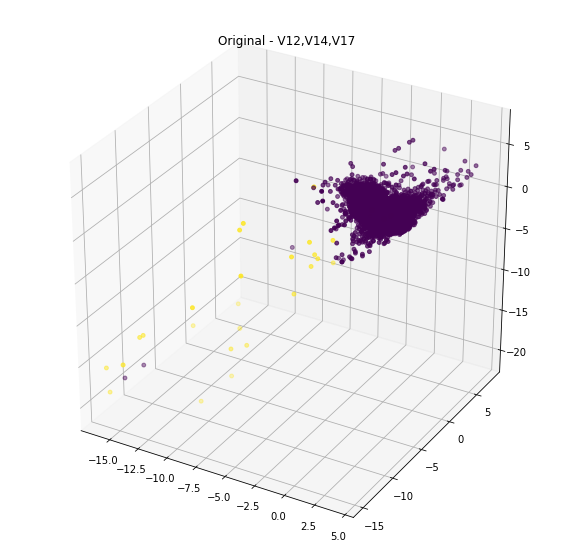

In [41]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_df.V12, valid_df.V14, valid_df.V17, c=valid_df.Class, marker='o', s=15)
plt.title('Original - V12,V14,V17')
plt.show()

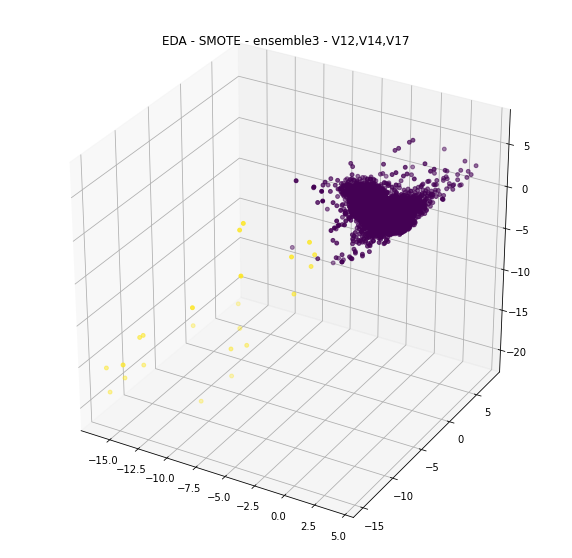

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_pred_df.V12, valid_pred_df.V14, valid_pred_df.V17, c=valid_pred_df.Class, marker='o', s=15)
plt.title('EDA - SMOTE - ensemble3 - V12,V14,V17')
plt.show()

In [40]:
'''vo_pred_test = vo_clf.predict(test_df)

SyntaxError: ignored

In [ ]:
'''test_df = pd.read_csv('/content/drive/MyDrive/신용카드AI/test.csv')
test_id = test_df['ID'].values.reshape(-1, 1)
final_test_pred = pd.DataFrame(np.concatenate((test_id, vo_pred_test.reshape(-1, 1)), axis=1), columns=['ID', 'Class'])
final_test_pred.head()

In [ ]:
'''final_test_pred.to_csv('/content/drive/MyDrive/신용카드AI/ADASYNtest_pred_soft_voting.csv', index = False)